In [1]:
import pandas as pd 
import numpy as np
import glob
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torchvision.models import resnet18

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
# читаем датасет
data_df = pd.read_csv("../input/dbf-krasnodar/train_dataset_train (1)/train.csv")

In [3]:
data_df.head(20)

id                                                img  sing1  sing2  \
0    807  5-avi-frame24_jpg.rf.5dec372f9195e9a88ff7dd3bd...      1      2   
1    121  6-avi-frame6431_jpg.rf.1ad48ac0ce545b88cefb946...      8      0   
2   1130  9-avi-frame1457_jpg.rf.634a979898a9caa4d106913...     21      0   
3    378  3-avi-frame499_jpg.rf.a0464ac21591528194da5bcf...      5      4   
4   1079  5-avi-frame5306_jpg.rf.8cd8b5643eea33f5f33714e...     48      0   
5    860  6-avi-frame3779_jpg.rf.14ff604c1af34671e5748ab...      4      5   
6    769  5-avi-frame16_jpg.rf.77026200267155755337fb456...      2      1   
7    298  5-avi-frame1531_jpg.rf.54c3c024dcf98b542ba9446...      1      2   
8    500  5-avi-frame3315_jpg.rf.78b197fe5bd8242fbe4c761...     32      4   
9    450  5-avi-frame3463_jpg.rf.a37b3477e30833ce9b5c749...     13      0   
10   209  5-avi-frame2817_jpg.rf.c8a224d205f88b5d352e1f0...      1      7   
11   889  6-avi-frame4066_jpg.rf.88435a075216c602f3ea2a9...      8      0   
12   773  6-avi-frame4966_jpg.rf.adb0616381f77fd9f7a95c7...     25      0   
13   425  5-avi-frame4754_jpg.rf.58c82411433bccf9bfe365c...     32     57   
14   421  6-avi-frame13355_jpg.rf.47b55150b4154c2da9853a...     15      0   
15   923  5-avi-frame229_jpg.rf.2109defad469fb8ef432dc9e...     26      0   
16   481  5-avi-frame2810_jpg.rf.93deab8ca54e1b8b1fd8acc...      1      7   
17   319  6-avi-frame4063_jpg.rf.f9972d8d9dc418b2127e69c...      8      0   
18   122  5-avi-frame5007_jpg.rf.800b69e584a95af7bcb3fa2...      6      0   
19    45  6-avi-frame13617_jpg.rf.e0e31ce7f9e6ef26c18af3...     15     35   

    sing3  sing4  sing5  sing6  sing7  sing8  
0      37      0      0      0      0      0  
1       0      0      0      0      0      0  
2       0      0      0      0      0      0  
3       0      0      0      0      0      0  
4       0      0      0      0      0      0  
5      14      0      0      0      0      0  
6      37      0      0      0      0      0  
7       0      0      0      0      0      0  
8       5      0      0      0      0      0  
9       0      0      0      0      0      0  
10      0      0      0      0      0      0  
11      0      0      0      0      0      0  
12      0      0      0      0      0      0  
13      5      4      0      0      0      0  
14      0      0      0      0      0      0  
15      0      0      0      0      0      0  
16      0      0      0      0      0      0  
17      0      0      0      0      0      0  
18      0      0      0      0      0      0  
19     17      0      0      0      0      0

In [4]:
data_df.isna().sum()

id       0
img      0
sing1    0
sing2    0
sing3    0
sing4    0
sing5    0
sing6    0
sing7    0
sing8    0
dtype: int64

In [5]:
vals = []
for i in range(8):
    vals += list(data_df.iloc[:,2+i].unique())
    
classes = np.unique(vals)
print(len(classes))
print(max(classes))
#sorted(classes)

68
69


In [6]:
allv  = []
for i in range(8):
    allv += list(data_df.iloc[:,2+i].values)
un, cnt = np.unique(allv, return_counts=True)
print(len(un))
un, cnt

68


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 67, 68, 69]),
 array([4530,  136,   66,    6,  199,  173,   18,   23,  296,   55,   86,
          36,    9,    7,   54,   42,   45,   11,    6,    7,    5,   10,
           9,    2,    3,   14,   37,    9,   48,   51,   24,    8,   11,
           2,    4,   27,    2,   35,    4,    3,    7,    4,   12,    6,
           3,    8,   14,    2,    3,    9,    1,    9,    2,    3,    4,
           1,    1,    5,    1,    3,    5,    1,    2,    1,    1,    1,
           1,    1]))

In [7]:
num_classes = max(classes) + 1
num_classes

70

In [8]:
data_df.shape


(778, 10)

In [9]:
target = []
for i in range(data_df.shape[0]):
    new_line = [0 for k in range(len(classes)+2)]
    for j in data_df.iloc[i, 2:].values:
        new_line[j] = 1
    #print(new_line)
    new_line[0] = 0
    target.append(new_line)
    #break
target = np.array(target)
target

array([[0, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

In [10]:
from os import listdir
train_path = "../input/dbf-krasnodar/train_dataset_train (1)/train/"
testpath = "../input/dbf-krasnodar/test_dataset_test (1)/test/"
print("Обучающей выборки " ,len(listdir(train_path)))
print("Тестовой выборки " ,len(listdir(testpath)))

Обучающей выборки  778
Тестовой выборки  388


In [11]:
#
for d in listdir(train_path):
    #print(d)
    image = cv2.imread(train_path+d)
    height, width, channels = image.shape
    print(height, width, channels)
    break

550 800 3


In [12]:
print(550/32,  800/32)
print(17*32,  25*32)

17.1875 25.0
544 800


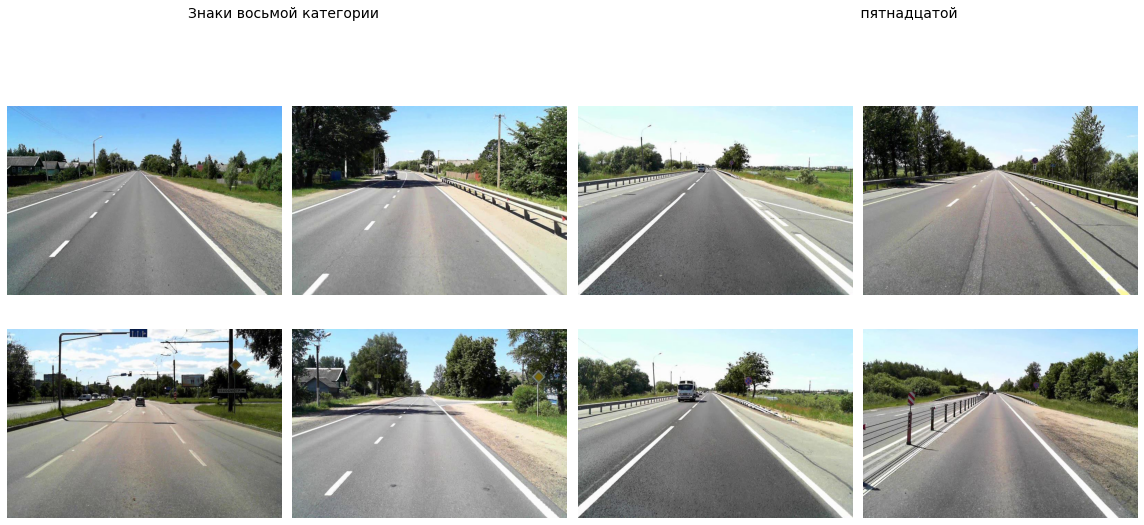

In [13]:
# посмотрим на картинки. let's look at the images

fig, axs = plt.subplots(2, 4, figsize=(16,8))
fig.suptitle(f'Знаки восьмой категории {" "*105} пятнадцатой', fontsize=14)

for i, name in zip(range(4), data_df[ data_df['sing1'] == 8 ].sample(4, random_state=42)['img']):
    axs[i // 2, (i % 2)].imshow(plt.imread(f"{train_path}{name}"))
    axs[i // 2, (i % 2)].axis('off')

for i, name in zip(range(4), data_df[ data_df['sing1'] == 15 ].sample(4, random_state=42)['img']):
    axs[i // 2, (i % 2)+2].imshow(plt.imread(f"{train_path}{name}"))
    axs[i // 2, (i % 2)+2].axis('off')

fig.tight_layout()
fig.subplots_adjust(top=0.88)

Обратим внимание, что знаки занимают очень малую часть изображения

In [14]:
class ImageDataset(Dataset):
    def __init__(self, images, targets, transform=None, test=False):

        self.images = images
        self.targets = targets
        self.transform = transform
        self.test = test

    def __getitem__(self, idx):
        # достаем имя изображения и ее лейбл
        #image_name, label = self.data_df.iloc[idx]['img'], self.data_df.iloc[idx]['sing4'],
        image_name = self.images[idx]
        # читаем картинку. read the image
        if (self.test):
            image = cv2.imread(f"{testpath}/{image_name}")
            label = [0 for k in range(len(classes)+2)]
        else:
            image = cv2.imread(f"{train_path}/{image_name}")
            label = self.targets[idx] 
            
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        # преобразуем, если нужно. transform it, if necessary
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.float32)
    
    def __len__(self):
        return len(self.images)

In [15]:
# задаем преобразование изображения.
# (272, 400)  (256,256) (544, 800)
train_transform = transforms.Compose([
    #transforms.Resize((256,256)),
    #transforms.Resize((272, 400) ),
    transforms.CenterCrop((544, 800)),
    #transforms.functional.adjust_brightness,
    transforms.RandomGrayscale(p=0.1),
    #transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
    #transforms.RandomRotation(degrees=(-10, 10), p=0.5),
    transforms.RandomAffine(10, translate=(0.1, 0.1), scale=(0.85,1.0)),
    #transforms.RandomPerspective(distortion_scale=0.5, p=0.5)
    transforms.ColorJitter(brightness=0.5, contrast=0.4, saturation=0.4),
    
    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

valid_transform = transforms.Compose([
    #transforms.Resize((256,256)),
    #transforms.Resize((272, 400)),
    transforms.CenterCrop((544, 800)),
    #transforms.functional.adjust_brightness,
    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

In [16]:
# разделим датасет на трейн и валидацию, чтобы смотреть на качество
train_x, valid_x, train_y, valid_y = train_test_split(data_df.img.values, target, test_size=0.2, random_state=42)

In [17]:
train_x.shape, valid_x.shape, len(train_y), len(valid_y)

((622,), (156,), 622, 156)

In [18]:
train_dataset = ImageDataset(train_x, train_y, train_transform)
valid_dataset = ImageDataset(valid_x, valid_y, valid_transform)

In [19]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=4,
                                           shuffle=True,
                                           num_workers=2)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=1,
                                           shuffle=False,
                                           num_workers=2)

In [20]:
next(iter(train_loader))[0].shape, next(iter(train_loader))[1].shape

(torch.Size([4, 3, 544, 800]), torch.Size([4, 70]))

In [21]:
next(iter(train_loader))[1][0][0]

tensor(0.)

## Вспомогательные функции

In [22]:
from typing import Tuple, List, Callable, Iterator, Optional, Dict, Any

class Recall:
    def __init__(self, epsilon=1e-8, b=1):
        self.epsilon = epsilon
        self.a = b*b

    def __call__(self, predictions: List[Dict[str, torch.Tensor]],
                 targets: List[Dict[str, torch.Tensor]], threshold=0.5) -> torch.Tensor:
        predictions = predictions >= threshold
        numerator = torch.sum(predictions * targets)
        denominator = torch.sum(targets)

        return numerator / (denominator + self.epsilon)
    
recall_metrics = Recall()   

## Модель

In [23]:
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [24]:
torch.cuda.empty_cache()

In [25]:
# Подргружаем модель

#model = models.resnet101(pretrained=True)

#model = models.efficientnet_b4("EfficientNet_B4_Weights.IMAGENET1K_V1")
model = models.efficientnet_b5("EfficientNet_B5_Weights.IMAGENET1K_V1")

#model.fc = nn.Linear(2048, num_classes)
#.classifier[1] = nn.Linear(in_features=1792, out_features=num_classes, bias=True) # efficientnet_b4
model.classifier[1] = nn.Linear(in_features=2048, out_features=num_classes, bias=True)

Downloading: "https://download.pytorch.org/models/efficientnet_b5_lukemelas-b6417697.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b5_lukemelas-b6417697.pth


  0%|          | 0.00/117M [00:00<?, ?B/s]

In [26]:
#model.load_state_dict(torch.load(f"../input/model-efnet-v28/model_epoch_48.pth"), strict=False)


In [27]:
loss = torch.nn.BCELoss()

In [28]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

In [29]:
n_epochs = 40

train_history = []
valid_history = []
recall_history = []

activation = nn.Sigmoid()
model.to(device)

best_loss = 10000
best_recall = 0

for i in range(n_epochs):
    # Iterate over batches

    model.train()
    epoch_loss = 0
    #iter_loss = 0

    for j, (x, y) in enumerate(train_loader):
        # Forward
        x = x.to(device)
        y = y.to(device)
        pred = model(x)
        
        
        # Compute loss
        loss_batch = loss(activation(pred), y)
        
        #print(j, loss_batch.item())
        
        epoch_loss += loss_batch.item()
        #iter_loss += loss_batch.item()
        
        #if (j > 0) and (j % 100 == 0):
        #    print("Iter # {}, loss = {:3}".format(j, iter_loss))
        #    iter_loss = 0
        
        #pbar.set_postfix({'loss_batch': float(loss_batch.item())})

        optimizer.zero_grad() # Do not forget this!
        # Backward: propagate gradients
        loss_batch.backward()
        
        # Update
        optimizer.step()
        
        #break
    
    # Validation    
    with torch.no_grad():
        model.eval() # Equivalent: classifier.eval()

        valid_loss = 0
        total_eval_recall_01 = 0

        
        for x, y in valid_loader:
            
            x = x.to(device)
            y = y.to(device)
            
            pred = model(x)
            loss_batch = loss(activation(pred), y)            
            valid_loss += loss_batch.item()
            
            total_eval_recall_01 += recall_metrics(activation(pred[:,1:]), y[:,1:])
            #total_eval_recall_02 += recall_score(torch.flatten(activation(pred[:,1:])) > 0.5, torch.flatten(y[:,1:]))

    train_history.append(epoch_loss)
    valid_history.append(valid_loss)
    
    print("\nEpoch # {}, Train loss = {:.4}, Valid loss = {:.4}".format(i+1, epoch_loss, valid_loss))
    

    
    
    avg_val_recall_01 = total_eval_recall_01 / len(valid_loader)
    recall_history.append(avg_val_recall_01)
    
    print("->  Recall: {0:.5f}  ".format(avg_val_recall_01))
    
    
    if avg_val_recall_01 > best_recall:
        print(f"Valid Score Improved ({best_recall:0.4f} ---> {avg_val_recall_01:0.4f})")
        best_recall = avg_val_recall_01
        torch.save(model.state_dict(), f"model_epoch_{i+1}.pth")
    if ((i + 1) % 4 == 0):
        print(f"Save model_epoch_{i+1}.pth")
        torch.save(model.state_dict(), f"model_epoch_{i+1}.pth")


Epoch # 1, Train loss = 24.34, Valid loss = 13.76
->  Recall: 0.34135  
Valid Score Improved (0.0000 ---> 0.3413)

Epoch # 2, Train loss = 13.69, Valid loss = 10.51
->  Recall: 0.52883  
Valid Score Improved (0.3413 ---> 0.5288)

Epoch # 3, Train loss = 11.06, Valid loss = 9.618
->  Recall: 0.59744  
Valid Score Improved (0.5288 ---> 0.5974)

Epoch # 4, Train loss = 9.759, Valid loss = 7.406
->  Recall: 0.62642  
Valid Score Improved (0.5974 ---> 0.6264)
Save model_epoch_4.pth

Epoch # 5, Train loss = 8.589, Valid loss = 7.976
->  Recall: 0.65557  
Valid Score Improved (0.6264 ---> 0.6556)

Epoch # 6, Train loss = 7.182, Valid loss = 7.939
->  Recall: 0.77094  
Valid Score Improved (0.6556 ---> 0.7709)

Epoch # 7, Train loss = 6.809, Valid loss = 7.21
->  Recall: 0.79612  
Valid Score Improved (0.7709 ---> 0.7961)

Epoch # 8, Train loss = 5.943, Valid loss = 5.615
->  Recall: 0.82329  
Valid Score Improved (0.7961 ---> 0.8233)
Save model_epoch_8.pth

Epoch # 9, Train loss = 6.282, Val

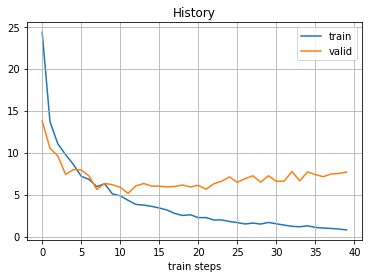

In [30]:
plt.figure()
plt.title("History")
#steps = list(range(0, len(train_history) + 1))[1:]
    
plt.plot(train_history, label='train', zorder=1)
plt.plot(valid_history, label='valid', zorder=2)

plt.xlabel('train steps')
    
plt.legend(loc='best')
plt.grid()

plt.show()

In [31]:
#best_bach = np.argmin(valid_history)
#print(best_bach+1, valid_history[best_bach])

#best_bach = np.argmax(recall_history)
#print(best_bach+1, recall_history[best_bach])

In [32]:
#model.load_state_dict(torch.load(f"./model_epoch_{best_bach+1}.pth"), strict=False)

In [33]:
true_data = np.array([0])
pred_data = np.array([0])

with torch.no_grad():
    model.eval() # Equivalent: classifier.eval()

    for x, y in train_loader:          
        x = x.to(device)
        y = y.to(device)          
        pred = model(x)
        true_data = np.concatenate((true_data, torch.flatten(y).cpu().detach().numpy()))
        pred_data = np.concatenate((pred_data, torch.flatten(activation(pred)).cpu().detach().numpy()))


#true_list        
#recall_metrics(activation(pred[:,1:]), y[:,1:])

print(true_data.shape, pred_data.shape)

(43541,) (43541,)


In [34]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#
def test_preds(threshold = 0.2):

    pred_data_true = pred_data>= threshold
    iter_num = len(pred_data_true) // num_classes

    pred_data_dig = []
    ground_true_data_dig = []

    for i in range(iter_num):
        pred_data_dig += [k * item for k, item in enumerate(pred_data_true[num_classes*i+1: num_classes*i+num_classes])]
        ground_true_data_dig += [k * item for k, item in enumerate(true_data[num_classes*i+1: num_classes*i+num_classes])]

    print(classification_report(ground_true_data_dig, pred_data_dig))
    print("f1", f1_score(ground_true_data_dig, pred_data_dig, average='macro'))
    print("recall", recall_score(ground_true_data_dig, pred_data_dig, average='macro'))

    #plt.figure(figsize=(20,20))
    #ax= plt.subplot()
    #cm = confusion_matrix(ground_true_data_dig, pred_data_dig)
    #sns.heatmap(cm, annot=True, fmt='g', ax=ax)
    
test_preds(threshold = 0.5)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     41546
         1.0       0.96      1.00      0.98       111
         2.0       1.00      1.00      1.00        50
         3.0       1.00      0.67      0.80         3
         4.0       1.00      0.98      0.99       166
         5.0       0.99      0.99      0.99       148
         6.0       1.00      1.00      1.00        15
         7.0       1.00      1.00      1.00        20
         8.0       1.00      1.00      1.00       235
         9.0       1.00      1.00      1.00        43
        10.0       0.99      0.97      0.98        69
        11.0       0.86      1.00      0.92        30
        12.0       1.00      1.00      1.00         9
        13.0       1.00      1.00      1.00         5
        14.0       0.86      0.95      0.90        40
        15.0       1.00      1.00      1.00        36
        16.0       1.00      0.97      0.99        37
        17.0       1.00    

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
def give_sings(number):
    sings = ['3.24', '1.16', '5.15.5', '5.19.1', '5.19.2', '1.20.1', '8.23',
    '2.1', '4.2.1', '8.22.1', '6.16', '1.22', '1.2', '5.16', '3.27',
    '6.10.1', '8.2.4', '6.12', '5.15.2', '3.13', '3.1', '3.20', '3.12',
    '7.14.2', '5.23.1', '2.4', '5.6', '4.2.3', '8.22.3', '5.15.1',
    '7.3', '3', '2.3.1', '3.11', '6.13', '5.15.4', '8.2.1', '1.34.3',
    '8.2.2', '5.15.3', '1.17', '4.1.1', '4.1.4', '3.25', '1.20.2',
    '8.22.2', '6.9.2', '3.2', '5.5', '5.15.7', '7.12', '8.2.3',
    '5.24.1', '1.25', '3.28', '5.9.1', '5.15.6', '8.1.1', '1.10',
    '6.11', '3.4', '6.10', '6.9.1', '8.2.5', '5.15', '4.8.2', '8.22',
    '5.21', '5.18']
    print(len(sings))
    print("Номеру", number, "соотвесвутет", sings[number-1], "знак")
give_sings(64)

69
Номеру 64 соотвесвутет 8.2.5 знак


In [36]:
threshold = 0.5

if True:
    pred_data_true = pred_data>= threshold
    iter_num = len(pred_data_true) // num_classes

    pred_data_dig = []
    ground_true_data_dig = []

    for i in range(iter_num):
        pred_data_dig += [k * item  for k, item in enumerate(pred_data_true[num_classes*i+1: num_classes*i+num_classes])]
        ground_true_data_dig += [k * item for k, item in enumerate(true_data[num_classes*i+1: num_classes*i+num_classes])]
        
print(np.unique(pred_data_dig, return_counts=True)[0])
print(np.unique(pred_data_dig, return_counts=True)[1])
print(np.unique(ground_true_data_dig, return_counts=True)[0])
print(np.unique(ground_true_data_dig, return_counts=True)[1])

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 54 55 57 58 59 60 61 63 66 67]
[41548   116    50     2   163   148    15    20   235    43    68    35
     9     5    44    36    36     9     5     4     5     7     7     2
     3    12    28     8    40    42    21     8     9     1     3    14
     1    27     4     3     6     3     9     4     2     7    11     2
     3     6     2     8     2     2     3     1     4     1     1     2
     1     1     1]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 54.
 55. 56. 57. 58. 59. 60. 61. 62. 63. 65. 66. 67.]
[41546   111    50     3   166   148    15    20   235    43    69    30
     9     5    40    36    37     9     5     6     4     7     7     2
     3 

**Validation metrics**

In [37]:
true_data = np.array([0])
pred_data = np.array([0])

with torch.no_grad():
    model.eval() # Equivalent: classifier.eval()

    for x, y in valid_loader:          
        x = x.to(device)
        y = y.to(device)          
        pred = model(x)
        true_data = np.concatenate((true_data, torch.flatten(y).cpu().detach().numpy()))
        pred_data = np.concatenate((pred_data, torch.flatten(activation(pred)).cpu().detach().numpy()))


#true_list        
#recall_metrics(activation(pred[:,1:]), y[:,1:])

print(true_data.shape, pred_data.shape)

(10921,) (10921,)


In [38]:
def test_preds(threshold = 0.5):

    pred_data_true = pred_data>= threshold
    iter_num = len(pred_data_true) // num_classes

    pred_data_dig = []
    ground_true_data_dig = []

    for i in range(iter_num):
        pred_data_dig += [k * item for k, item in enumerate(pred_data_true[num_classes*i+1: num_classes*i+num_classes])]
        ground_true_data_dig += [k * item for k, item in enumerate(true_data[num_classes*i+1: num_classes*i+num_classes])]

    print(classification_report(ground_true_data_dig, pred_data_dig))
    print("f1", f1_score(ground_true_data_dig, pred_data_dig, average='macro'))
    print("recall", recall_score(ground_true_data_dig, pred_data_dig, average='macro'))
    #plt.figure(figsize=(20,20))
    #ax= plt.subplot()
    #cm = confusion_matrix(ground_true_data_dig, pred_data_dig)
    #sns.heatmap(cm, annot=True, fmt='g', ax=ax)
    
test_preds(threshold = 0.5)

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00     10443
         1.0       0.83      1.00      0.91        25
         2.0       1.00      0.88      0.93        16
         3.0       1.00      0.33      0.50         3
         4.0       0.91      0.88      0.89        33
         5.0       0.81      0.88      0.85        25
         6.0       1.00      1.00      1.00         3
         7.0       0.67      0.67      0.67         3
         8.0       0.97      0.97      0.97        61
         9.0       0.92      1.00      0.96        12
        10.0       0.82      0.82      0.82        17
        11.0       0.38      1.00      0.55         6
        13.0       1.00      1.00      1.00         2
        14.0       0.57      0.57      0.57        14
        15.0       0.86      1.00      0.92         6
        16.0       0.75      0.75      0.75         8
        17.0       1.00      1.00      1.00         2
        18.0       0.33    

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1

6-avi-frame13282_jpg.rf.cd11624e141a0485b72c4e1fba9ce85f.jpg
True labels
[ 6 10]
Predicted labels
[6]


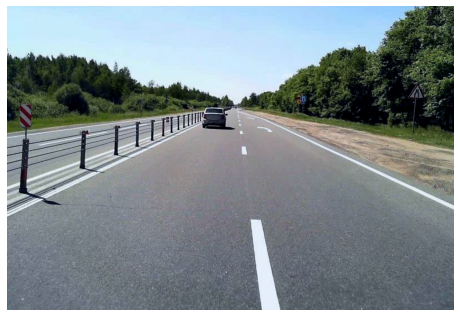

6-avi-frame10340_jpg.rf.b6cf39ae42035e6f15695992f569b725.jpg
True labels
[ 4  5 11]
Predicted labels
[ 4  5 11]


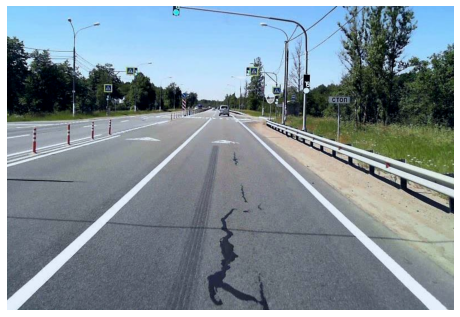

3-avi-frame514_jpg.rf.dc1152c557a92d865683181febd6566f.jpg
True labels
[ 1  5 20 41]
Predicted labels
[1 4 5]


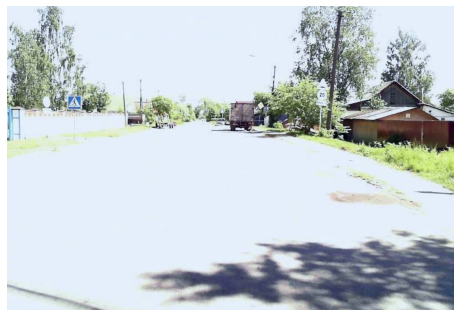

6-avi-frame4049_jpg.rf.a8f5d35a4498dd6c2282b8d1f4f32bce.jpg
True labels
8
Predicted labels
[8]


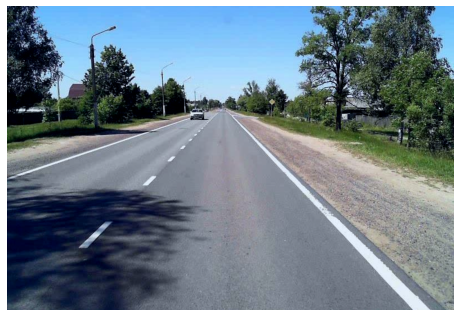

5-avi-frame4894_jpg.rf.76d50ae123a03e7788b266c7f8033df3.jpg
True labels
51
Predicted labels
[51]


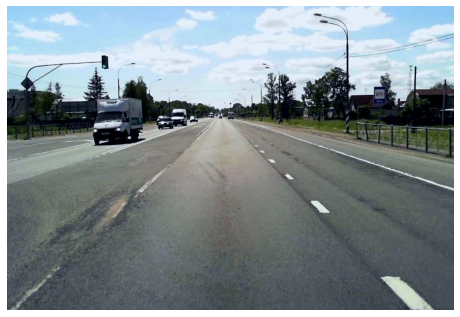

3-avi-frame681_jpg.rf.31842d3de8f346ef989ee08488999832.jpg
True labels
26
Predicted labels
[26]


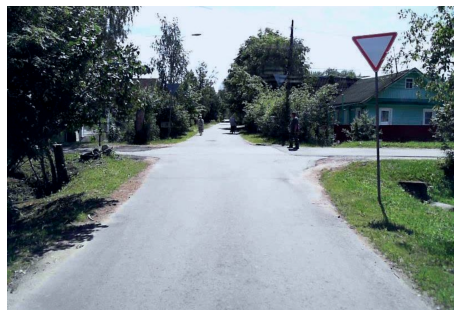

5-avi-frame4978_jpg.rf.18939ef95cd2afb16747a2b6bf1a7171.jpg
True labels
[ 4  5 11]
Predicted labels
[ 4  5 11 15 67]


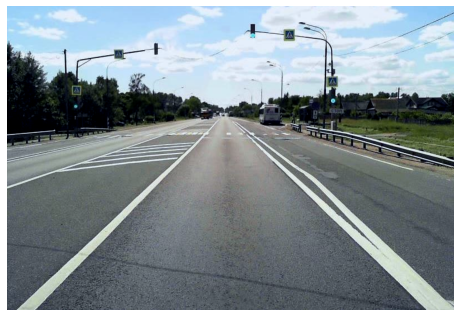

9-avi-frame1398_jpg.rf.0b8ca5c544cf716a3641421e1cd32b08.jpg
True labels
8
Predicted labels
[8]


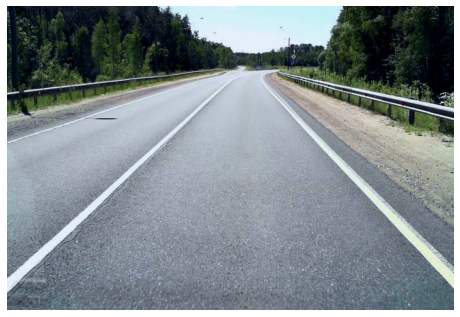

6-avi-frame4121_jpg.rf.64405c178c70bed84b618ed52943219e.jpg
True labels
[ 4  5  8 14]
Predicted labels
[ 4  5  8 14]


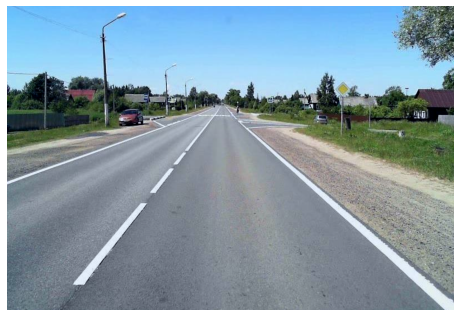

6-avi-frame4365_jpg.rf.c152992c8fc885d3b77c365ada0169ab.jpg
True labels
8
Predicted labels
[8]


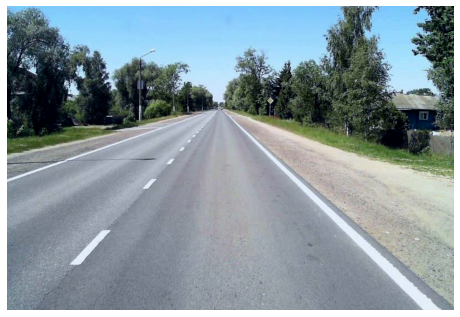

6-avi-frame4458_jpg.rf.9e043f799350d9b01069c182ef555606.jpg
True labels
[4 5 8]
Predicted labels
[4 5 8]


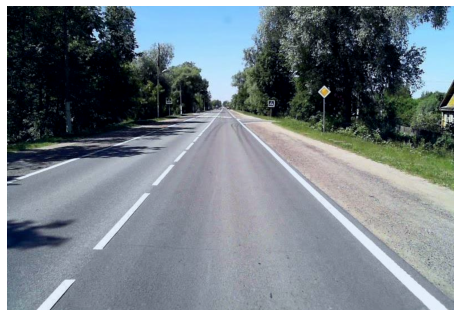

3-avi-frame423_jpg.rf.470148994b4410b5a7f7f7eb926b64e6.jpg
True labels
[28 29]
Predicted labels
[28 29]


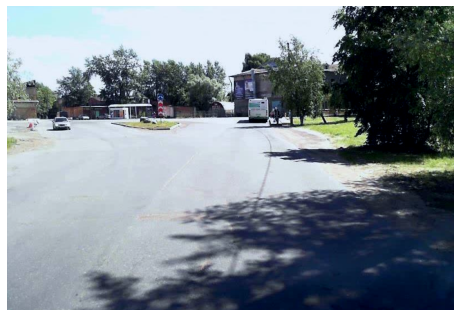

6-avi-frame13217_jpg.rf.f46df0e8db93ce65ba12290874f313f0.jpg
True labels
16
Predicted labels
[10 16]


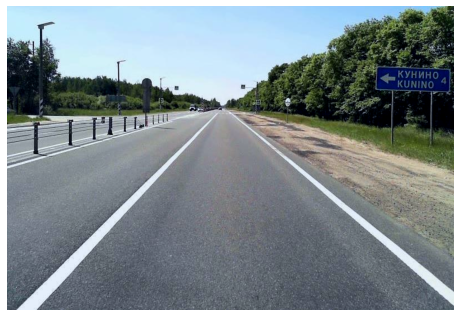

6-avi-frame75_jpg.rf.546f94e47ad0d061a7ac95ae9d6e732b.jpg
True labels
[ 8 18 49]
Predicted labels
[ 8 18 49]


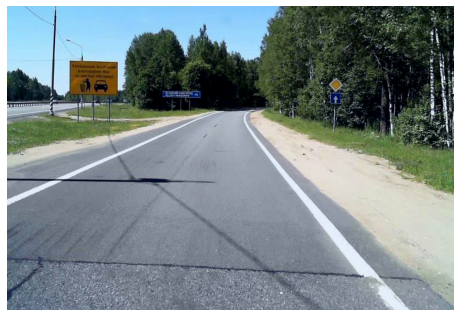

6-avi-frame6487_jpg.rf.c4a880fc020347983281e990837814a9.jpg
True labels
[4 5 8]
Predicted labels
[4 8]


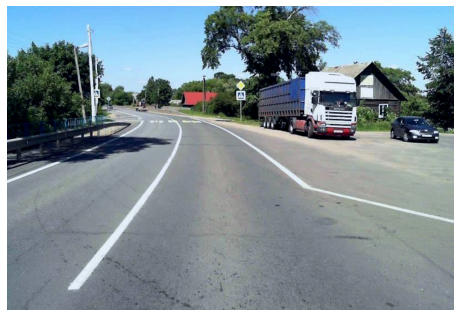

6-avi-frame4576_jpg.rf.8780eec122abf32efb3744cf110122f0.jpg
True labels
8
Predicted labels
[8]


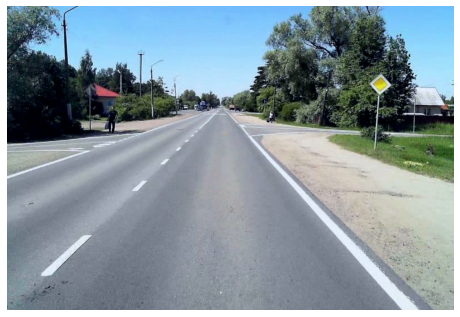

6-avi-frame12436_jpg.rf.314bdd244335f9089707ca6310893716.jpg
True labels
[ 4  9 10 11 14]
Predicted labels
[ 4  5  9 10 11 14]


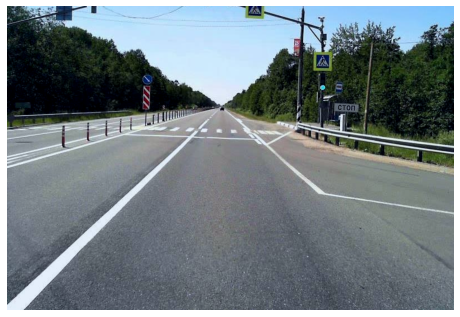

5-avi-frame3337_jpg.rf.c55117138a367d66763eeee7a87e8085.jpg
True labels
[4 5]
Predicted labels
[ 4  5 11]


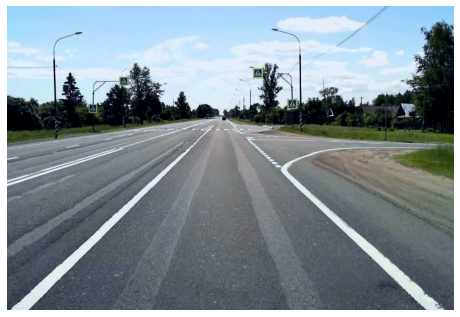

6-avi-frame14506_jpg.rf.29a113ea34e47e8895d16b589db9faf9.jpg
True labels
[28 29]
Predicted labels
[28 29]


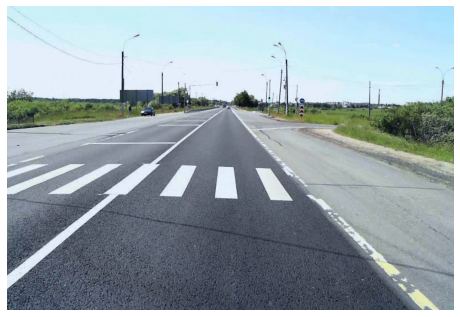

6-avi-frame4371_jpg.rf.3e9d280436c16c3159d507b44eac2804.jpg
True labels
8
Predicted labels
[8]


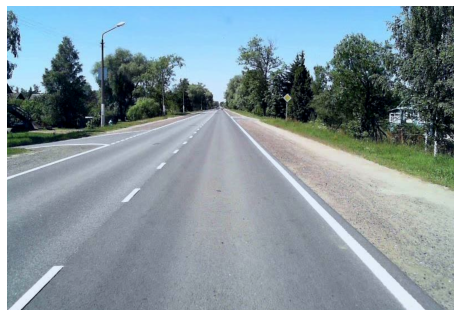

In [39]:
def test_model(i, dataset, model, thr=0.5):
    x, y = dataset[i]
    
    print(dataset.images[i])
    print("True labels")
    print(np.argwhere(y.numpy() == 1.).squeeze())
    x = x.unsqueeze(dim=0)
    x = x.to(device)
           
    pred = model(x)
    pred_prob = activation(pred).cpu().detach().numpy()
    pred_labels = np.unique(np.argwhere(pred_prob > thr))#.squeeze()
    print("Predicted labels")
    print(pred_labels[1:])
    
    tensor = x[0].cpu().permute(1, 2, 0).numpy()
    tensor = 0.224 * tensor + 0.406

    #print(img.size)
    plt.figure(figsize=(8, 8))
    plt.imshow(tensor)
    plt.axis('off')
    plt.show()

for i in [1, 2, 3, 4, 5, 6, 7, 8, 9, 15, 25, 30, 32, 35, 40, 45, 50, 55, 60, 65,]:
    test_model(i, valid_dataset, model)


# Тест

In [40]:
# читаем датасет
test_df = pd.read_csv("../input/dbf-krasnodar/test_dataset_test (1)/test.csv")
test_df.head()

id                                                img
0   754  6-avi-frame14887_jpg.rf.bb0bf6b4b122c23e1b33a9...
1    29  5-avi-frame2916_jpg.rf.1ecdbbc129d33896fd25b9b...
2  1157  5-avi-frame2871_jpg.rf.f73998176f8a19ee03f8704...
3  1049  6-avi-frame5752_jpg.rf.a067b0fc55b770c9b10bb7a...
4   715  6-avi-frame5678_jpg.rf.f140419d224703d49fe65db...

In [41]:
test_dataset = ImageDataset(test_df.img.values, None, valid_transform, test=True)

In [42]:
threshold = 0.5

with torch.no_grad():
    model.eval() 
    for i in range(len(test_dataset)):
            x = test_dataset[i][0]
            x = x.unsqueeze(dim=0)
            x = x.to(device)
           
            pred = model(x)
            pred_prob = activation(pred).cpu().detach().numpy()
            #print(pred_prob)
            #args = np.argsort(pred_prob.cpu().detach().numpy())#[-8:]
            args = np.argwhere(pred_prob[0] > threshold).squeeze(axis=-1)
            #print(args)
            args = list(args) #[-8:]
            
            
            if 0 in args: args.remove(0)
            args += [0 for i in range(8)]
            args = args[:8]
            print(i, test_dataset.images[i])
            print(args)
            test_df.loc[i ,["sing1", "sing2", "sing3", "sing4", "sing5" ,"sing6", "sing7", "sing8"]] = args
            #break

0 6-avi-frame14887_jpg.rf.bb0bf6b4b122c23e1b33a9e05d006b06.jpg
[22, 31, 0, 0, 0, 0, 0, 0]
1 5-avi-frame2916_jpg.rf.1ecdbbc129d33896fd25b9b8dfdbfc43.jpg
[4, 5, 11, 0, 0, 0, 0, 0]
2 5-avi-frame2871_jpg.rf.f73998176f8a19ee03f870416674385b.jpg
[8, 0, 0, 0, 0, 0, 0, 0]
3 6-avi-frame5752_jpg.rf.a067b0fc55b770c9b10bb7a822425229.jpg
[1, 8, 16, 0, 0, 0, 0, 0]
4 6-avi-frame5678_jpg.rf.f140419d224703d49fe65db505e7f1ce.jpg
[8, 0, 0, 0, 0, 0, 0, 0]
5 5-avi-frame2656_jpg.rf.74ad968c68c4018408fde487873dcc4e.jpg
[1, 2, 37, 0, 0, 0, 0, 0]
6 6-avi-frame13288_jpg.rf.25eebbce0617c60a8555c4fddf921730.jpg
[1, 0, 0, 0, 0, 0, 0, 0]
7 5-avi-frame355_jpg.rf.4d1a110ace34c0a58c7304439f84e4d5.jpg
[1, 2, 37, 0, 0, 0, 0, 0]
8 5-avi-frame2512_jpg.rf.86ff5fb4533226b55c57ec031eaf59f2.jpg
[1, 14, 0, 0, 0, 0, 0, 0]
9 6-avi-frame5558_jpg.rf.ad41e5b5ca397c2313f4b1adb2c33c67.jpg
[4, 5, 8, 16, 0, 0, 0, 0]
10 3-avi-frame506_jpg.rf.b5c0446b13adc22ec30b713b1c109f1f.jpg
[4, 5, 20, 0, 0, 0, 0, 0]
11 6-avi-frame5918_jpg.rf.d6fb5cc

In [43]:

test_df[["sing1", "sing2", "sing3", "sing4", "sing5" ,"sing6", "sing7", "sing8"]] = test_df[["sing1", "sing2", "sing3", "sing4", "sing5" ,"sing6", "sing7", "sing8"]].astype("int")
    
test_df

id                                                img  sing1  sing2  \
0     754  6-avi-frame14887_jpg.rf.bb0bf6b4b122c23e1b33a9...     22     31   
1      29  5-avi-frame2916_jpg.rf.1ecdbbc129d33896fd25b9b...      4      5   
2    1157  5-avi-frame2871_jpg.rf.f73998176f8a19ee03f8704...      8      0   
3    1049  6-avi-frame5752_jpg.rf.a067b0fc55b770c9b10bb7a...      1      8   
4     715  6-avi-frame5678_jpg.rf.f140419d224703d49fe65db...      8      0   
..    ...                                                ...    ...    ...   
383   243  3-avi-frame433_jpg.rf.b29d8fb61048b3016805a62e...     28     29   
384   921  6-avi-frame4125_jpg.rf.e1dbdc7a7421bc9bc95a58f...      4      5   
385   881  6-avi-frame1424_jpg.rf.e171549738da66b200b537c...      8      0   
386   503  5-avi-frame2867_jpg.rf.c0bbb8942eeb6fac582e6b6...      8      0   
387   599  6-avi-frame14403_jpg.rf.2da20f70e9a1360fe4753e...      1      2   

     sing3  sing4  sing5  sing6  sing7  sing8  
0        0      0      0      0      0      0  
1       11      0      0      0      0      0  
2        0      0      0      0      0      0  
3       16      0      0      0      0      0  
4        0      0      0      0      0      0  
..     ...    ...    ...    ...    ...    ...  
383      0      0      0      0      0      0  
384      8     14      0      0      0      0  
385      0      0      0      0      0      0  
386      0      0      0      0      0      0  
387      0      0      0      0      0      0  

[388 rows x 10 columns]

In [44]:
out_df = test_df.drop("img", axis=1)

In [45]:
out_df

id  sing1  sing2  sing3  sing4  sing5  sing6  sing7  sing8
0     754     22     31      0      0      0      0      0      0
1      29      4      5     11      0      0      0      0      0
2    1157      8      0      0      0      0      0      0      0
3    1049      1      8     16      0      0      0      0      0
4     715      8      0      0      0      0      0      0      0
..    ...    ...    ...    ...    ...    ...    ...    ...    ...
383   243     28     29      0      0      0      0      0      0
384   921      4      5      8     14      0      0      0      0
385   881      8      0      0      0      0      0      0      0
386   503      8      0      0      0      0      0      0      0
387   599      1      2      0      0      0      0      0      0

[388 rows x 9 columns]

In [46]:
out_df.to_csv(f'/kaggle/working/submission_0710_03.csv', index=False)

In [47]:
#v2 Recalls: 0.59105 Score = 0.383244